In [1]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [2]:
df = pd.read_csv('./data/InsNova_data_2023_train.csv')
df.drop(['id'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,...,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0
0,0.77,0.444504,SEDAN,4,M,D,3,petrol,147,67.0,...,S,1,weekday,6pm - 12am,6,640.448137,1.0,0,0,0.0
1,4.45,0.562183,STNWG,1,M,A,3,petrol,158,76.0,...,S,1,weekday,6am - 12pm,12,683.749691,0.0,0,0,0.0
2,4.90,0.465244,STNWG,1,F,A,3,petrol,159,58.0,...,M,1,weekday,6pm - 12am,6,653.656117,1.0,0,0,0.0
3,0.48,0.271039,PANVN,4,M,A,4,petrol,80,72.0,...,S,1,weekday,12pm - 6pm,12,642.574671,0.0,0,0,0.0
4,0.85,0.141624,SEDAN,4,F,A,5,petrol,126,91.0,...,S,0,weekday,6am - 12pm,6,647.175035,0.0,0,0,0.0


In [3]:
df_dummies = pd.get_dummies(df, columns=['veh_body', 'veh_age', 'gender', 'area', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind'])

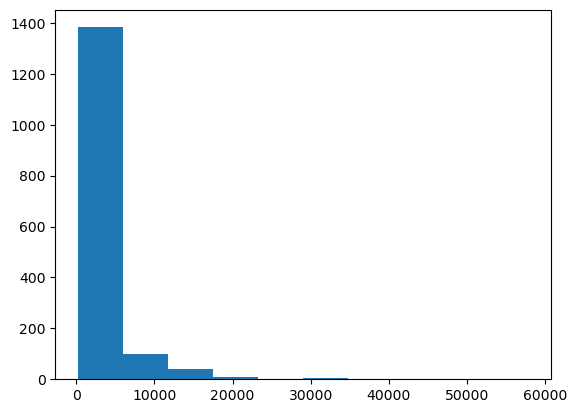

In [4]:
plt.hist(df[df['claimcst0'] != 0]['claimcst0'])
plt.show()

In [5]:
cost_df = df_dummies.drop(columns=['clm', 'numclaims'])

In [6]:
majority_class = cost_df[cost_df['claimcst0'] == 0]
minority_class = cost_df[cost_df['claimcst0'] != 0]

print(majority_class.shape)
print(minority_class.shape)

(21077, 64)
(1542, 64)


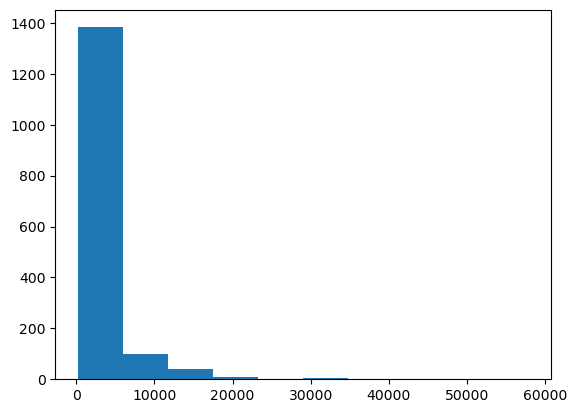

In [7]:
plt.hist(minority_class['claimcst0'])
plt.show()

In [8]:
oversampled_minority = resample(minority_class, replace=True, n_samples=5 * len(majority_class))

oversampled_minority.shape

(21077, 64)

In [9]:
cost_balanced_df = pd.concat([majority_class, oversampled_minority])
cost_balanced_df = cost_balanced_df.sample(frac=1)
cost_balanced_df.reset_index(drop=True, inplace=True)

cost_balanced_df[cost_balanced_df['claimcst0'] == 0].shape

(21077, 64)

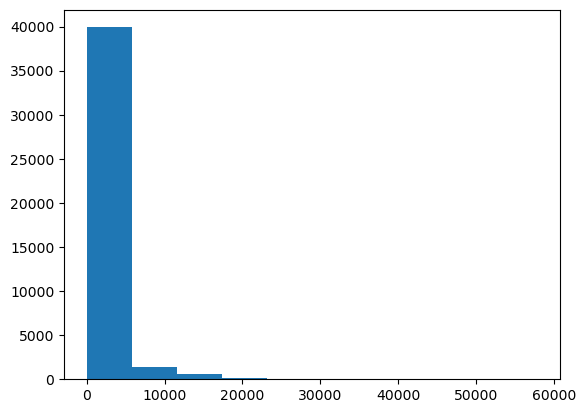

In [10]:
plt.hist(cost_balanced_df['claimcst0'])
plt.show()

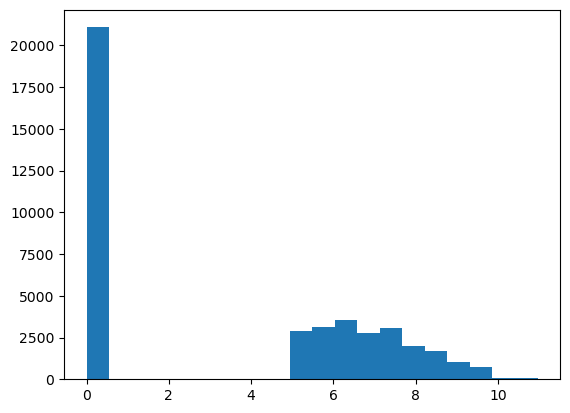

In [11]:
plt.hist(np.log(cost_balanced_df['claimcst0'] + 1), bins=20)
plt.show()

In [12]:
cost_x, cost_y = cost_balanced_df.drop(columns=['claimcst0']), cost_balanced_df['claimcst0']
cost_y = np.log(cost_y + 1)

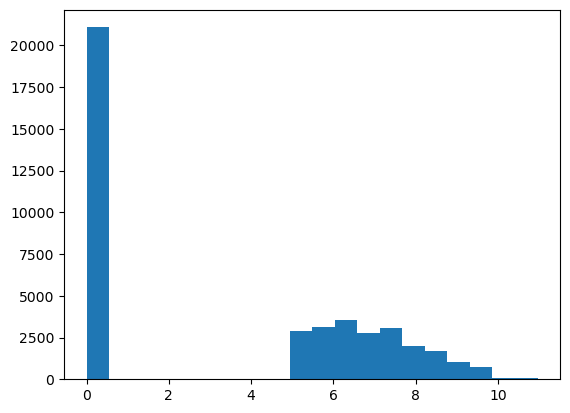

In [13]:
plt.hist(cost_y, bins=20)
plt.show()

In [14]:
x_train, x_test, y_train, y_test = train_test_split(cost_x, cost_y, test_size=1 / 3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1 / 3)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(18734, 63) (18734,) (9368, 63) (9368,) (14052, 63) (14052,)


In [15]:
def tweedie_loss(y_true, y_pred, p=1.5):
    a = y_true * np.exp(y_pred * (1 - p)) / (1 - p)
    b = np.exp(y_pred * (2 - p)) / (2 - p)

    loss = -a + b

    return loss.mean()

In [16]:
space = {'max_depth': hp.quniform('max_depth', 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.uniform('n_estimators', 5, 500),
        'tweedie_variance_power': hp.uniform('tweedie_variance_power', 1, 2)
        }

pred_min = np.log(200 + 1)

def objective(space):
    power = space['tweedie_variance_power']

    clf = xgb.XGBRegressor(n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'],
                           reg_alpha=int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                           colsample_bytree=int(space['colsample_bytree']), objective='reg:tweedie', tweedie_variance_power=power)
    
    evaluation = [(x_train, y_train), (x_val, y_val)]
    
    clf.fit(x_train, y_train, eval_set=evaluation, early_stopping_rounds=100, verbose=False)
    

    pred = clf.predict(x_test)

    try:
        # pred = np.clip(pred, a_min=0, a_max=None)
        # loss = tweedie_loss(y_test, pred, power)
        loss = mean_squared_log_error(y_test, pred)

        print(f'Test loss: {loss}')

        return {'loss': loss, 'status': STATUS_OK }
    
    except:
        return {'loss': np.inf, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print(f'Best hyperparameters: \n{best_hyperparams}')

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Test loss: 2.1268638442762966                          
Test loss: 2.033759648242241                                                     
Test loss: 2.0620432534091617                                                    
Test loss: 2.1283796548677407                                                   
Test loss: 2.1283796548677407                                                   
Test loss: 2.105513132074757                                                    
Test loss: 2.1283796548677407                                                   
Test loss: 2.110715831814474                                                    
Test loss: 2.108404282366185                                                    
Test loss: 2.1283796548677407                                                   
Test loss: 2.087991706141306                                                     
Test loss: 2.1283796548677407                                                    
Test loss: 2.1283796548677407                    

In [17]:
# params = {'colsample_bytree': 0.6735575572484057, 'gamma': 1.4744332064192558, 'max_depth': 16.0, 'min_child_weight': 2.0, 'n_estimators': 448.7350874787879, 'reg_alpha': 54.0, 'reg_lambda': 0.1756894781548466, 'tweedie_variance_power': 1.0018468259675535}
params = {'colsample_bytree': 0.5187321978262073, 'gamma': 1.0535825732071775, 'max_depth': 13.0, 'min_child_weight': 6.0, 'n_estimators': 332.3464111037629, 'reg_alpha': 46.0, 'reg_lambda': 0.47309431044419487, 'tweedie_variance_power': 1.0592019958987218}
params['max_depth'] = int(params['max_depth'])
params['min_child_weight'] = int(params['min_child_weight'])
params['n_estimators'] = int(params['n_estimators'])
params['reg_alpha'] = int(params['reg_alpha'])
params['objective'] = 'reg:tweedie'
power = params['tweedie_variance_power']
cost_model = xgb.XGBRegressor(**params)
cost_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5187321978262073, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.0535825732071775, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, n_estimators=332, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', predictor=None, ...)

In [18]:
pred = cost_model.predict(x_test)
mean_squared_log_error(y_test, pred)

0.6383682108843222

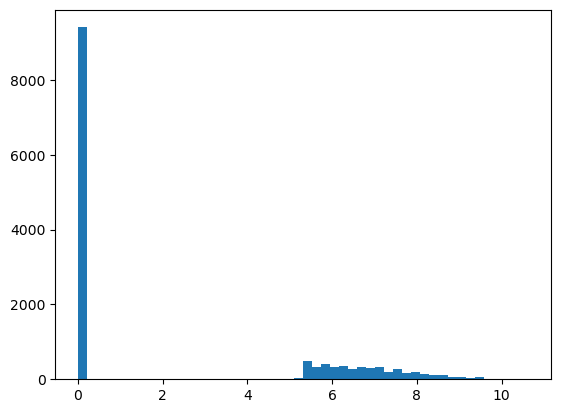

In [19]:
plt.hist(pred, bins=50)
plt.show()

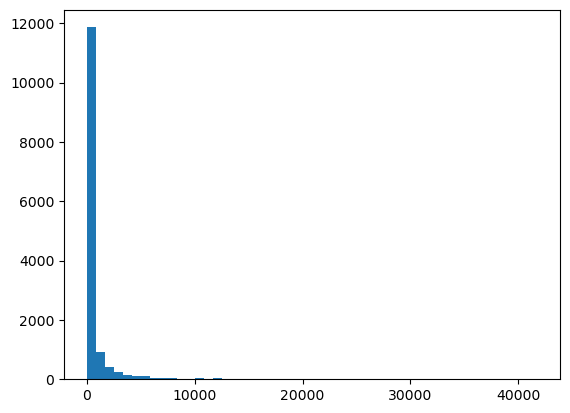

In [20]:
plt.hist(np.exp(pred) - 1, bins=50)
plt.show()

In [21]:
print((np.exp(pred) - 1).max())
pred.max()

41774.613


10.640068

In [22]:
val_df = pd.read_csv('./data/InsNova_data_2023_vh.csv')
ids = val_df['id']
val_df.drop(['id'], axis=1, inplace=True)
val_df.reset_index(drop=True, inplace=True)

val_df.head()

,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,driving_history_score,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind
0,3.40,0.076279,STNWG,2,M,B,4,petrol,174,83,black,S,1,weekday,6pm - 12am,6,648.247594,0
1,2.55,0.093443,STNWG,2,F,A,3,petrol,181,65,yellow,M,0,weekday,12am - 6 am,12,637.752677,0
2,3.04,0.157762,STNWG,2,F,E,4,petrol,136,64,white,S,1,weekday,12pm - 6pm,12,661.483786,0
3,2.05,0.560735,MIBUS,4,M,C,6,dissel,164,82,gray,M,1,weekday,6am - 12pm,12,647.846365,0
4,1.93,0.258275,HBACK,2,M,C,4,dissel,89,48,black,S,0,weekday,6am - 12pm,12,640.257550,0


In [23]:
val_df_dummies = pd.get_dummies(val_df, columns=['veh_body', 'veh_age', 'gender', 'area', 'agecat', 'engine_type', 'veh_color', 'marital_status', 'e_bill', 'time_of_week_driven', 'time_driven', 'trm_len', 'high_education_ind'])
val_df_dummies = val_df_dummies.rename(columns={'high_education_ind_0': 'high_education_ind_0.0', 'high_education_ind_1': 'high_education_ind_1.0'})

0.0
10715.768
0.0
1.3989521


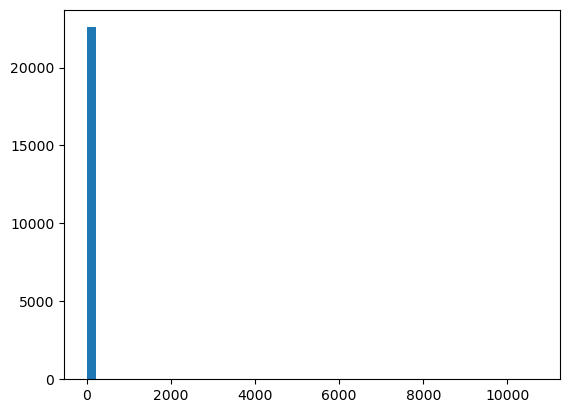

In [24]:
predicted_costs = cost_model.predict(val_df_dummies)
predicted_costs = np.exp(predicted_costs) - 1

print(predicted_costs.min())
print(predicted_costs.max())
print(np.median(predicted_costs))
print(predicted_costs.mean())

# plt.hist(df['claimcst0'], bins=50)
plt.hist(predicted_costs, bins=50)
plt.show()

In [25]:
submission_df = pd.DataFrame({'id': ids, 'Predict': predicted_costs.reshape(-1,)})
submission_df.head()

,id,Predict
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [26]:
submission_df.to_csv('./data/submission.csv', index=False)